In [1]:
import numpy as np
import sys 
import os
import matplotlib.pyplot as plt
os.chdir('/storage/filament/codes/')
#from utils import *
import copy 
import tqdm
import cv2

In [4]:
box_num = '01'
#subbox_num = ''

subbox_list = ['1','2','3','4','5','6','7','8']

distance = '40Mpc'

if distance == '30Mpc':
    box_size = 37
if distance == '40Mpc':
    box_size = 50

for subbox_num in subbox_list:
    data_path = '/storage/filament/data/box'+box_num +'/'
    dens_result_path = '/storage/filament/result/cluster_3d/' + distance + '/density_log_plot/box' + box_num + '/subbox0' +subbox_num + '/'
    temp_result_path = '/storage/filament/result/cluster_3d/' + distance + '/temp_threshold/box' + box_num + '/subbox0' +subbox_num + '/'
    dens_smooth_path_3 =  '/storage/filament/result/cluster_3d/' + distance + '/density_smooting_plot_3/box' + box_num + '/subbox0' +subbox_num + '/'
    dens_smooth_path_5 =  '/storage/filament/result/cluster_3d/' + distance + '/density_smooting_plot_5/box' + box_num + '/subbox0' +subbox_num + '/'
    data_type = ['a','f','g']
    # a = density
    # f = temperature
    # g = xray   
    
    dens = np.zeros(256**3,dtype='float64')
    dens = np.genfromtxt(data_path + '256den18' + data_type[0] + '+1024+' + subbox_num,dtype='float64')
    dens_mat = dens.reshape([256,256,256])

    temp = np.zeros(256**3,dtype='float64')
    temp = np.genfromtxt(data_path + '256den18' + data_type[1] + '+1024+' + subbox_num,dtype='float64')
    temp_mat = temp.reshape([256,256,256])

    index_path = '/storage/filament/data/box'+box_num +'+Cinfo/'
    index = np.genfromtxt(index_path + 'box' + box_num + '+xlum+' + subbox_num+'.dat',dtype='uint8')

    x_index = index[:,3]-1
    y_index = index[:,2]-1
    z_index = index[:,1]-1

    coords = np.array(list(zip(x_index,y_index,z_index)))
    coords = np.array(sorted(coords, key=lambda x:x[2] ))

    box_list =[]
    temp_point = np.zeros([box_size*2,box_size*2,box_size*2],dtype='float64')
    dens_3d = np.zeros([box_size*2,box_size*2,box_size*2],dtype='float64')
    smooth_dens = np.zeros([box_size*2,box_size*2,box_size*2],dtype='float64')
    
    cluster_peak_thres = 2*1.16*10**7
               
    min_thres = 0.5
    max_thres = 0.7
    min_thres_2 = 1.0
    max_thres_2 = 1.5
    
    num=0

    print('box_num ', box_num, 'subbox_num ',subbox_num, 'density')

    for n,(ix,iy,iz) in enumerate(tqdm.tqdm(coords)):
        if (ix < box_size or ix>256-box_size or iy < box_size or iy > 256-box_size or iz <box_size or iz >256-box_size):
            continue
        else:
            if temp_mat[ix,iy,iz] >= cluster_peak_thres:
                dens_3d[:,:,:] = dens_mat[-box_size+ix:box_size+ix,-box_size+iy:box_size+iy,-box_size+iz:box_size+iz]


                if not os.path.isdir(dens_result_path + str(num) + '/'):
                     os.makedirs(dens_result_path + str(num) + '/')
                os.chdir(dens_result_path + str(num) + '/')            


                for nn in range(2*box_size):
                    plt.figure(figsize=[30,30])
                    plt.imsave(str(nn) +'.png',np.log10(dens_3d[:,:,nn]),vmin=-1,vmax=4,cmap='gray',dpi=300,format='png')
   

#                 smooth_dens = smooting_3d(dens_3d,2)

#                 if not os.path.isdir(dens_smooth_path_3 + str(num) + '/'):
#                      os.makedirs(dens_smooth_path_3 + str(num) + '/')
#                 os.chdir(dens_smooth_path_3 + str(num) + '/')            

#                 for nn in range(2*box_size):
#                     plt.figure(figsize=[30,30])
#                     plt.imsave(str(nn) +'.png',np.log10(smooth_dens[:,:,nn]),vmin=-2.5,vmax=4.5,cmap='gray',dpi=300,format='png')

                    
                smooth_dens = smooting_3d(dens_3d,4)
                smooth_dens = smooth_dens[2:100-2,2:100-2,2:100-2]
                
                if not os.path.isdir(dens_smooth_path_5 + str(num) + '/'):
                     os.makedirs(dens_smooth_path_5 + str(num) + '/')
                os.chdir(dens_smooth_path_5 + str(num) + '/')            

                for nn in range(2*box_size-4):
                    plt.figure(figsize=[30,30])
                    plt.imsave(str(nn) +'.png',np.log10(smooth_dens[:,:,nn+2]),vmin=1,vmax=3,cmap='gray',dpi=300,format='png')

                
                
                num = num+1
                
     

    num=0


    temp_3d = np.zeros([2*box_size,2*box_size,2*box_size])
    temp_3d_thres = np.zeros([2*box_size,2*box_size,2*box_size])

    print('box_num ', box_num, 'subbox_num ',subbox_num, 'temperature')
    for n,(ix,iy,iz) in enumerate(tqdm.tqdm(coords)):
        if (ix < box_size or ix>256-box_size or iy < box_size or iy > 256-box_size or iz <box_size or iz >256-box_size):
            continue
        else:
            if temp_mat[ix,iy,iz] >= cluster_peak_thres:
                temp_3d[:,:,:] = (temp_mat[-box_size+ix:box_size+ix,-box_size+iy:box_size+iy,-box_size+iz:box_size+iz])
                temp_3d_thres = np.zeros([2*box_size,2*box_size,2*box_size])

                for iix in range(2*box_size):
                    for iiy in range(2*box_size):
                        for iiz in range(2*box_size):
                            if temp_3d[iix,iiy,iiz] > min_thres*1.16*10**7  and temp_3d[iix,iiy,iiz] < max_thres*1.16*10**7:
                                temp_3d_thres[iix,iiy,iiz] = 1  #
                            elif temp_3d[iix,iiy,iiz] > min_thres_2*1.16*10**7  and temp_3d[iix,iiy,iiz] < max_thres_2*1.16*10**7:
                                temp_3d_thres[iix,iiy,iiz] = 2  #
                            else:
                                pass#

                if not os.path.isdir(temp_result_path + str(num) + '/'):
                     os.makedirs(temp_result_path + str(num) + '/')
                os.chdir(temp_result_path + str(num) + '/')            

                for nn in range(2*box_size):
                    plt.figure(figsize=[30,30])
                    plt.imsave(str(nn) +'.png',temp_3d_thres[:,:,nn],vmin=0,vmax=2,cmap='gray',dpi=300,format='png')


                num = num+1

  0%|          | 0/718 [00:00<?, ?it/s]

box_num  02 subbox_num  1 density


/home/ha/anaconda3/envs/research_filament/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/ha/anaconda3/envs/research_filament/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/ha/anaconda3/envs/research_filament/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may 

box_num  02 subbox_num  1 temperature


/home/ha/anaconda3/envs/research_filament/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  0%|          | 0/635 [00:00<?, ?it/s]

box_num  02 subbox_num  2 density


  0%|          | 0/635 [00:00<?, ?it/s]

box_num  02 subbox_num  2 temperature


  0%|          | 0/709 [00:00<?, ?it/s]

box_num  02 subbox_num  3 density


  0%|          | 0/709 [00:00<?, ?it/s]

box_num  02 subbox_num  3 temperature


  0%|          | 0/664 [00:00<?, ?it/s]

box_num  02 subbox_num  4 density


  0%|          | 0/664 [00:00<?, ?it/s]

box_num  02 subbox_num  4 temperature


  0%|          | 0/770 [00:00<?, ?it/s]

box_num  02 subbox_num  5 density


  0%|          | 0/770 [00:00<?, ?it/s]

box_num  02 subbox_num  5 temperature


  0%|          | 0/691 [00:00<?, ?it/s]

box_num  02 subbox_num  6 density


  0%|          | 0/691 [00:00<?, ?it/s]

box_num  02 subbox_num  6 temperature


  0%|          | 0/641 [00:00<?, ?it/s]

box_num  02 subbox_num  7 density


  0%|          | 0/641 [00:00<?, ?it/s]

box_num  02 subbox_num  7 temperature


  0%|          | 0/608 [00:00<?, ?it/s]

box_num  02 subbox_num  8 density


  0%|          | 0/608 [00:00<?, ?it/s]

box_num  02 subbox_num  8 temperature


100%|██████████| 608/608 [00:01<00:00, 555.10it/s]


<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [17]:
box_num = '02'
#subbox_num = ''

subbox_list = ['1','2','3','4','5','6','7','8']

distance = '40Mpc'

if distance == '30Mpc':
    box_size = 37
if distance == '40Mpc':
    box_size = 50

for subbox_num in subbox_list:
    data_path = '/storage/filament/data/box'+box_num +'/'
    dens_result_path = '/storage/filament/result/cluster_3d/' + distance + '/density_log_plot/box' + box_num + '/subbox0' +subbox_num + '/'
    temp_result_path = '/storage/filament/result/cluster_3d/' + distance + '/temp_threshold/box' + box_num + '/subbox0' +subbox_num + '/'
    dens_smooth_path_3 =  '/storage/filament/result/cluster_3d/' + distance + '/density_smooting_plot_3/box' + box_num + '/subbox0' +subbox_num + '/'
    dens_smooth_path_5 =  '/storage/filament/result/cluster_3d/' + distance + '/density_smooting_plot_5/box' + box_num + '/subbox0' +subbox_num + '/'
    data_type = ['a','f','g']
    # a = density
    # f = temperature
    # g = xray   
    
    dens = np.zeros(256**3,dtype='float64')
    dens = np.genfromtxt(data_path + '256den18' + data_type[0] + '+1024+' + subbox_num,dtype='float64')
    dens_mat = dens.reshape([256,256,256])

    temp = np.zeros(256**3,dtype='float64')
    temp = np.genfromtxt(data_path + '256den18' + data_type[1] + '+1024+' + subbox_num,dtype='float64')
    temp_mat = temp.reshape([256,256,256])

    index_path = '/storage/filament/data/box'+box_num +'+Cinfo/'
    index = np.genfromtxt(index_path + 'box' + box_num + '+xlum+' + subbox_num+'.dat',dtype='uint8')

    x_index = index[:,3]-1
    y_index = index[:,2]-1
    z_index = index[:,1]-1

    coords = np.array(list(zip(x_index,y_index,z_index)))
    coords = np.array(sorted(coords, key=lambda x:x[2] ))

    box_list =[]
    temp_point = np.zeros([box_size*2,box_size*2,box_size*2],dtype='float64')
    dens_3d = np.zeros([box_size*2,box_size*2,box_size*2],dtype='float64')
    smooth_dens = np.zeros([box_size*2,box_size*2,box_size*2],dtype='float64')
    
    cluster_peak_thres = 2*1.16*10**7
               
    min_thres = 0.5
    max_thres = 0.7
    min_thres_2 = 1.0
    max_thres_2 = 1.5
    
    num=0

    print('box_num ', box_num, 'subbox_num ',subbox_num, 'density')

    for n,(ix,iy,iz) in enumerate(tqdm.tqdm(coords)):
        if (ix < box_size or ix>256-box_size or iy < box_size or iy > 256-box_size or iz <box_size or iz >256-box_size):
            continue
        else:
            if temp_mat[ix,iy,iz] >= cluster_peak_thres:
                dens_3d[:,:,:] = dens_mat[-box_size+ix:box_size+ix,-box_size+iy:box_size+iy,-box_size+iz:box_size+iz]

               
                smooth_dens = smooting_3d(dens_3d,4)
                smooth_dens = smooth_dens[2:100-2,2:100-2,2:100-2]
                
                if not os.path.isdir(dens_smooth_path_5 + str(num) + '/'):
                     os.makedirs(dens_smooth_path_5 + str(num) + '/')
                os.chdir(dens_smooth_path_5 + str(num) + '/')            

                for nn in range(2*box_size-4):
                    plt.figure(figsize=[30,30])
                    plt.imsave(str(nn) +'.png',np.log10(smooth_dens[:,:,nn]),vmin=1,vmax=3,cmap='gray',dpi=300,format='png')

                    
                
                num = num+1
               
     



  0%|          | 0/718 [00:00<?, ?it/s]

box_num  02 subbox_num  1 density


/home/ha/anaconda3/envs/research_filament/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  0%|          | 0/635 [00:00<?, ?it/s]

box_num  02 subbox_num  2 density


  0%|          | 0/709 [00:00<?, ?it/s]

box_num  02 subbox_num  3 density


  0%|          | 0/664 [00:00<?, ?it/s]

box_num  02 subbox_num  4 density


  0%|          | 0/770 [00:00<?, ?it/s]

box_num  02 subbox_num  5 density


  0%|          | 0/691 [00:00<?, ?it/s]

box_num  02 subbox_num  6 density


  0%|          | 0/641 [00:00<?, ?it/s]

box_num  02 subbox_num  7 density


  0%|          | 0/608 [00:00<?, ?it/s]

box_num  02 subbox_num  8 density


100%|██████████| 608/608 [00:06<00:00, 97.44it/s]


<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [80]:
box_num = '01'
#subbox_num = ''

#subbox_list = ['1','2','3','4','5','6','7','8']
subbox_list = ['3']
distance = '40Mpc'

if distance == '30Mpc':
    box_size = 37
if distance == '40Mpc':
    box_size = 50

for subbox_num in subbox_list:
    data_path = '/storage/filament/data/box'+box_num +'/'
    #dens_result_path = '/storage/filament/result/cluster_3d/' + distance + '/density_log_plot/box' + box_num + '/subbox0' +subbox_num + '/'
    #temp_result_path = '/storage/filament/result/cluster_3d/' + distance + '/temp_threshold/box' + box_num + '/subbox0' +subbox_num + '/'
    #dens_smooth_path_3 =  '/storage/filament/result/cluster_3d/' + distance + '/density_smooting_plot_3/box' + box_num + '/subbox0' +subbox_num + '/'
    dens_smooth_path_5 =  '/storage/filament/result/cluster_3d/40Mpc/density_smooting_plot_5/smooth_test/'
    data_type = ['a','f','g']
    # a = density
    # f = temperature
    # g = xray   
    
    dens = np.zeros(256**3,dtype='float64')
    dens = np.genfromtxt(data_path + '256den18' + data_type[0] + '+1024+' + subbox_num,dtype='float64')
    dens_mat = dens.reshape([256,256,256])

    temp = np.zeros(256**3,dtype='float64')
    temp = np.genfromtxt(data_path + '256den18' + data_type[1] + '+1024+' + subbox_num,dtype='float64')
    temp_mat = temp.reshape([256,256,256])
    
    index_path = '/storage/filament/data/box'+box_num +'+Cinfo/'
    index = np.genfromtxt(index_path + 'box' + box_num + '+xlum+' + subbox_num+'.dat',dtype='uint8')

    x_index = index[:,3]-1
    y_index = index[:,2]-1
    z_index = index[:,1]-1

    coords = np.array(list(zip(x_index,y_index,z_index)))
    coords = np.array(sorted(coords, key=lambda x:x[2] ))

    box_list =[]
    temp_point = np.zeros([box_size*2,box_size*2,box_size*2],dtype='float64')
    dens_3d = np.zeros([box_size*2,box_size*2,box_size*2],dtype='float64')
    smooth_dens = np.zeros([box_size*2,box_size*2,box_size*2],dtype='float64')
    
    cluster_peak_thres = 2*1.16*10**7
            
    num=0

    print('box_num ', box_num, 'subbox_num ',subbox_num, 'density')

box_num  01 subbox_num  3 density


In [84]:
num=0
for n,(ix,iy,iz) in enumerate(tqdm.tqdm(coords)):
    if (ix < box_size or ix>256-box_size or iy < box_size or iy > 256-box_size or iz <box_size or iz >256-box_size):
        continue
    else:
        if temp_mat[ix,iy,iz] >= cluster_peak_thres:
            dens_3d[:,:,:] = dens_mat[-box_size+ix:box_size+ix,-box_size+iy:box_size+iy,-box_size+iz:box_size+iz]


            smooth_dens = smooting_3d(dens_3d,4)
            smooth_dens = smooth_dens[2:100-2,2:100-2,2:100-2]

            if not os.path.isdir(dens_smooth_path_5 + str(num) + '/'):
                 os.makedirs(dens_smooth_path_5 + str(num) + '/')
            os.chdir(dens_smooth_path_5 + str(num) + '/')            


            for nn in range(2*box_size-4):
                plt.figure(figsize=[30,30])
                plt.imsave(str(nn) +'.png',np.log10(smooth_dens[:,:,nn]*0.28/(0.044)),vmin=0,vmax=2,cmap='gray',dpi=300,format='png')


                
            num = num+1
               
     

            




  0%|          | 0/674 [00:00<?, ?it/s]/home/ha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


 23%|██▎       | 154/674 [00:04<00:15, 33.62it/s]

 50%|█████     | 338/674 [00:09<00:09, 35.53it/s]

 55%|█████▌    | 374/674 [00:13<00:18, 16.58it/s]

 65%|██████▍   | 437/674 [00:18<00:15, 15.48it/s]

 67%|██████▋   | 450/674 [00:23<00:34,  6.47it/s]

100%|██████████| 674/674 [00:23<00:00, 28.82it/s]

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [81]:
def smooting_3d(array,smooth_size):
    array_len = array.shape[0]
    half_smooth_size = int(smooth_size/2)
    #smooth_array = np.zeros([array_len-smooth_size,array_len-smooth_size,array_len-smooth_size])
    smooth_array = np.zeros([array_len,array_len,array_len])
    for i in range(half_smooth_size,array_len-half_smooth_size):
        for j in range(half_smooth_size,array_len-half_smooth_size):
            for k in range(half_smooth_size,array_len-half_smooth_size):
                
                #smoothing  + array[i,j,k]
                #smooth_array[i,j,k] = np.mean(array[i-half_smooth_size:i+half_smooth_size+1,j-half_smooth_size:j+half_smooth_size+1,k-half_smooth_size:k+half_smooth_size+1])
                smooth_array[i,j,k] = (1/(smooth_size+1)**3)*np.sum(array[i-half_smooth_size:i+half_smooth_size+1,j-half_smooth_size:j+half_smooth_size+1,k-half_smooth_size:k+half_smooth_size+1])    
    
    #print("b",smooth_array.shape)
    return smooth_array

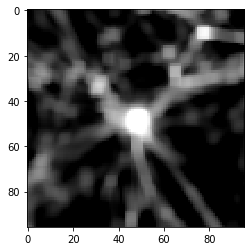

In [79]:
plt.imshow(np.log10(smooth_dens[:,:,50]*0.28/(0.044)),vmin=0,vmax=2,cmap='gray')

i=20
np.log10((1/5**3)*np.sum(dens_3d[i:i+5,i:i+5,i:i+5]))

In [ ]:
for i in range(10):
    print(i)

In [39]:
np.max(np.log10(smooth_dens))

2.6796272221950552